## Two Moons Normalizing Flow Using Distrax + Haiku
Neural Spline Flow based off of `distrax` [documentation](https://github.com/deepmind/distrax/blob/master/examples/flow.py) for a flow. For a more detailed walkthrough of the math behind normalizing flow, see this [notebook's](https://colab.research.google.com/github/nsanghi/probml-notebooks/blob/add_mnist_spline_flow_jax/notebooks/flow_spline_mnist_jax.ipynb#scrollTo=l0K_D4QX74gV) example using MNIST. Code to load 2 moons example dataset sourced from Chris Waites's jax-flows [demo](https://github.com/ChrisWaites/jax-flows/blob/master/examples/intro.ipynb).

In [1]:
!pip install -U dm-haiku distrax optax

     |████████████████████████████████| 309 kB 24.5 MB/s 
     |████████████████████████████████| 272 kB 39.4 MB/s 
     |████████████████████████████████| 136 kB 51.4 MB/s 
     |████████████████████████████████| 70 kB 9.5 MB/s 


In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn import datasets, preprocessing
import distrax
import jax
import jax.numpy as jnp
import numpy as np
import haiku as hk
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

# key = jax.random.PRNGKey(1234)

# Plotting 2 moons dataset
Code taken directly from Chris Waites's jax-flows [demo](https://github.com/ChrisWaites/jax-flows/blob/master/examples/intro.ipynb). This is the distribution we want to create a bijection to from a simple base distribution, such as a gaussian distribution.

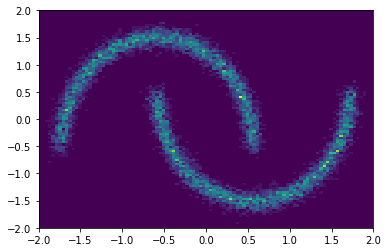

In [3]:
n_samples = 10000
plot_range = [(-2, 2), (-2, 2)]
n_bins = 100

scaler = preprocessing.StandardScaler()
X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
X = scaler.fit_transform(X)
plt.hist2d(X[:, 0], X[:, 1], bins=n_bins, range=plot_range)[-1]

## Creating the normalizing flow in distrax+haiku
Instead of a uniform distribution, we use a normal distribution as the base distribution. This makes more sense for a standardized two moons dataset that is scaled according to a normal distribution using `sklearn`'s `StandardScaler()`. Using a uniform base distribution will result in `inf` and `nan` loss.

In [5]:
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple

# Hyperparams - change these to experiment
flow_num_layers = 8 
mlp_num_layers = 4 
hidden_size = 1000 
num_bins = 8 
batch_size = 512
learning_rate = 1e-4
eval_frequency = 100

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any


# Functions to create a distrax normalizing flow
def make_conditioner(event_shape: Sequence[int],
                     hidden_sizes: Sequence[int],
                     num_bijector_params: int) -> hk.Sequential:
  """Creates an MLP conditioner for each layer of the flow."""
  return hk.Sequential([
      hk.Flatten(preserve_dims=-len(event_shape)),
      hk.nets.MLP(hidden_sizes, activate_final=True),
      # We initialize this linear layer to zero so that the flow is initialized
      # to the identity function.
      hk.Linear(
          np.prod(event_shape) * num_bijector_params,
          w_init=jnp.zeros,
          b_init=jnp.zeros),
      hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1),
  ])


def make_flow_model(event_shape: Sequence[int],
                    num_layers: int,
                    hidden_sizes: Sequence[int],
                    num_bins: int) -> distrax.Transformed:
  """Creates the flow model."""
  # Alternating binary mask.
  mask = jnp.arange(0, np.prod(event_shape)) % 2
  mask = jnp.reshape(mask, event_shape)
  mask = mask.astype(bool)

  def bijector_fn(params: Array):
    return distrax.RationalQuadraticSpline(
        params, range_min=-2., range_max=2.)

  # Number of parameters for the rational-quadratic spline:
  # - `num_bins` bin widths
  # - `num_bins` bin heights
  # - `num_bins + 1` knot slopes
  # for a total of `3 * num_bins + 1` parameters.
  num_bijector_params = 3 * num_bins + 1

  layers = []
  for _ in range(num_layers):
    layer = distrax.MaskedCoupling(
        mask=mask,
        bijector=bijector_fn,
        conditioner=make_conditioner(event_shape, hidden_sizes,
                                     num_bijector_params))
    layers.append(layer)
    # Flip the mask after each layer.
    mask = jnp.logical_not(mask)

  # We invert the flow so that the `forward` method is called with `log_prob`.
  flow = distrax.Inverse(distrax.Chain(layers))

  # Making base distribution normal distribution
  mu = jnp.zeros(event_shape) 
  sigma = jnp.ones(event_shape) 
  base_distribution = distrax.Independent(
      distrax.MultivariateNormalDiag(mu, sigma))
  return distrax.Transformed(base_distribution, flow)


def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
  # ds = tfds.load("mnist", split=split, shuffle_files=True)
  ds = split
  ds = ds.shuffle(buffer_size=10 * batch_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=1000)
  ds = ds.repeat()
  return iter(tfds.as_numpy(ds))


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:
  data = batch.astype(np.float32)
  return data


@hk.without_apply_rng
@hk.transform
def model_sample(key: PRNGKey, num_samples: int) -> Array:
  model = make_flow_model(
      event_shape=TWO_MOONS_SHAPE,
      num_layers=flow_num_layers,
      hidden_sizes=[hidden_size] * mlp_num_layers,
      num_bins=num_bins)
  return model.sample(seed=key, sample_shape=[num_samples])


@hk.without_apply_rng
@hk.transform
def log_prob(data: Array) -> Array:
  model = make_flow_model(
      event_shape=TWO_MOONS_SHAPE,
      num_layers=flow_num_layers,
      hidden_sizes=[hidden_size] * mlp_num_layers,
      num_bins=num_bins)
  return model.log_prob(data)


def loss_fn(params: hk.Params, prng_key: PRNGKey, batch: Batch) -> Array:
  data = prepare_data(batch, prng_key)
  # Loss is average negative log likelihood.
  loss = -jnp.mean(log_prob.apply(params, data))
  return loss


@jax.jit
def eval_fn(params: hk.Params, batch: Batch) -> Array:
  data = prepare_data(batch)  # We don't dequantize during evaluation.
  loss = -jnp.mean(log_prob.apply(params, data))
  return loss


## Setting up the optimizer

In [6]:
optimizer = optax.adam(learning_rate)

@jax.jit
def update(params: hk.Params,
            prng_key: PRNGKey,
            opt_state: OptState,
            batch: Batch) -> Tuple[hk.Params, OptState]:
  """Single SGD update step."""
  grads = jax.grad(loss_fn)(params, prng_key, batch)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

## Training the flow


In [7]:
# Event shape
TWO_MOONS_SHAPE = (2,)

# Create tf dataset from sklearn dataset
dataset = tf.data.Dataset.from_tensor_slices(X)

# Splitting into train/validate ds
train = dataset.skip(2000)
val = dataset.take(2000)

# load_dataset(split: tfds.Split, batch_size: int)
train_ds = load_dataset(train, 512)
valid_ds = load_dataset(val, 512)

# Initializing PRNG and Neural Net params
prng_seq = hk.PRNGSequence(1)
params = log_prob.init(next(prng_seq), np.zeros((1, *TWO_MOONS_SHAPE)))
opt_state = optimizer.init(params)

training_steps = 1000

for step in range(training_steps):
  params, opt_state = update(params, next(prng_seq), opt_state,
                              next(train_ds))

  if step % eval_frequency == 0:
    val_loss = eval_fn(params, next(valid_ds))
    print(f"STEP: {step:5d}; Validation loss: {val_loss:.3f}")


STEP:     0; Validation loss: 2.816
STEP:   100; Validation loss: 1.526
STEP:   200; Validation loss: 1.509
STEP:   300; Validation loss: 1.349
STEP:   400; Validation loss: 1.341
STEP:   500; Validation loss: 1.208
STEP:   600; Validation loss: 1.322
STEP:   700; Validation loss: 1.282
STEP:   800; Validation loss: 1.299
STEP:   900; Validation loss: 1.307


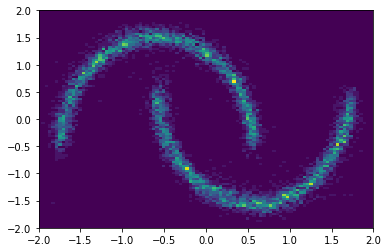

In [8]:
n_samples = 10000
plot_range = [(-2, 2), (-2, 2)]
n_bins = 100

X_transf = model_sample.apply(params, next(prng_seq), num_samples=n_samples)
plt.hist2d(X_transf[:, 0], X_transf[:, 1], bins=n_bins, range=plot_range)[-1]